# Solving combinatorial optimization problems using QAOA

This example based on [this Qiskit tutorial notebook](https://qiskit.org/textbook/ch-applications/qaoa.html) runs the same general example of Quantum Approximate Optimization Algorithm (QAOA) in PyQrack.

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

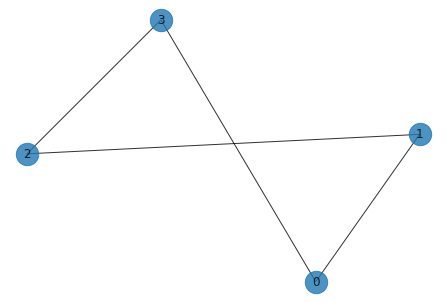

In [2]:
import networkx as nx

G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3])
G.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 0)])
nx.draw(G, with_labels=True, alpha=0.8, node_size=500)

In [3]:
from collections import Counter
from pyqrack import QrackSimulator, Pauli

def maxcut_obj(x, G):
    """
    Given a (bitstring-equivalent) integer as a solution,
    this function returns the number of edges shared
    between the two partitions of the graph.
    
    Args:
        x: str
           solution bitstring
           
        G: networkx graph
        
    Returns:
        obj: float
             Objective
    """
    obj = 0
    for i, j in G.edges():
        if ((x >> i) & 1) != ((x >> j) & 1):
            obj -= 1
            
    return obj


def compute_expectation(counts, G):
    
    """
    Computes expectation value based on measurement results
    
    Args:
        counts: dict
                key as integer, val as count
           
        G: networkx graph
        
    Returns:
        avg: float
             expectation value
    """
    
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = maxcut_obj(bitstring, G)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count


def run_qaoa_circ(G, theta, shots):
    
    """
    Creates a parametrized qaoa circuit
    
    Args:  
        G: networkx graph
        theta: list
               unitary parameters
                     
    Returns:
        collections.Counter of measurement results
    """
    
    nqubits = len(G.nodes())
    p = len(theta)//2  # number of alternating unitaries
    qc = QrackSimulator(nqubits)
    
    beta = theta[:p]
    gamma = theta[p:]
    
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    
    for irep in range(0, p):
        
        # problem unitary
        for pair in list(G.edges()):
            qc.mch([pair[0]], pair[1])
            qc.r(Pauli.PauliZ, 2 * gamma[irep], pair[1])
            qc.mch([pair[0]], pair[1])

        # mixer unitary
        for i in range(0, nqubits):
            qc.r(Pauli.PauliX, 2 * beta[irep], i)
            
    return Counter(qc.measure_shots(range(0, nqubits), shots))

# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(G, p, shots=512):
    
    """
    Runs parametrized circuit
    
    Args:
        G: networkx graph
        p: int,
           Number of repetitions of unitaries
    """
    
    def execute_circ(theta):

        counts = run_qaoa_circ(G, theta, shots)
        
        return compute_expectation(counts, G)
    
    return execute_circ

In [4]:
from scipy.optimize import minimize


expectation = get_expectation(G, p=1)

res = minimize(expectation, 
                      [1.0, 1.0], 
                      method='COBYLA')
res

Device #0, Loaded binary from: /home/iamu/.qrack/qrack_ocl_dev_Intel(R)_Gen9_HD_Graphics_NEO.ir
Device #1, Loaded binary from: /home/iamu/.qrack/qrack_ocl_dev_NVIDIA_GeForce_RTX_3080_Laptop_GPU.ir


     fun: -2.53125
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 31
  status: 1
 success: True
       x: array([1.19989005, 0.55735742])